In [1]:
# reference: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
! nvidia-smi

Sat Sep 19 19:02:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    34W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import sys
S6_PROJECT_PATH = '/content/drive/My Drive/TSAI/TSAI-2/S6/Save_Modified_Model/'

In [5]:
# !7z x '/content/drive/My Drive/TSAI/TSAI-2/S6/Save_Model/CARS.7z' -o'/content/' -ir!'CARS/RED/*.jpg'

In [6]:
from __future__ import print_function
# %matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.autograd import Variable

from pathlib import Path
from torchsummary import summary

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


Inputs
------

Let’s define some inputs for the run:

-  **dataroot** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   `here <https://github.com/pytorch/examples/issues/70>`__ for more
   details
-  **nc** - number of color channels in the input images. For color
   images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the
   generator
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs




In [7]:
# Root directory for dataset
dataroot = "/content/CARS"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 2000
# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.9

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Data
----


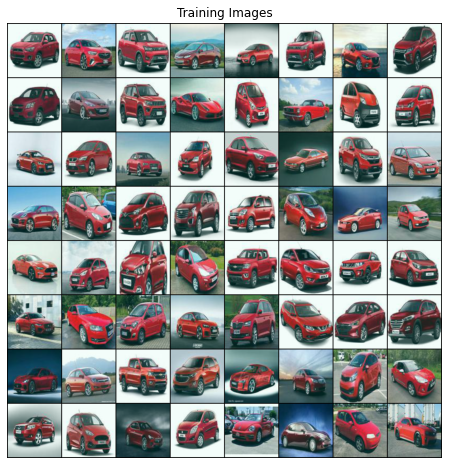

In [8]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.570838093757629, 0.479552984237671, 0.491760671138763), (0.279659748077393, 0.309973508119583, 0.311098515987396))
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Implementation
-------------


In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv' ) != -1:
        nn.init.kaiming_normal_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator



In [10]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(

Discriminator 



In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.Dropout2d(0.25),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.Dropout2d(0.25),
            nn.LeakyReLU(0.2, inplace=True),            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.Dropout2d(0.25),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.Dropout2d(0.25),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()
        )
        self.linear = nn.Linear(ndf * 8*16,1)

    def forward(self, input):
        return self.main(input) 
        # x = self.main(input)
        # x = x.view(x.shape[0], -1)
        # x = self.linear(x)
        # x = nn.Sigmoid()(x)
        # return x

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout2d(p=0.25, inplace=False)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout2d(p=0.25, inplace=False)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)

In [14]:
summary(netD, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]          73,728
       BatchNorm2d-4          [-1, 128, 32, 32]             256
         Dropout2d-5          [-1, 128, 32, 32]               0
         LeakyReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]         147,456
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         Dropout2d-9          [-1, 128, 16, 16]               0
        LeakyReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11            [-1, 256, 8, 8]         294,912
      BatchNorm2d-12            [-1, 256, 8, 8]             512
        Dropout2d-13            [-1, 256, 8, 8]               0
        LeakyReLU-14            [-1, 25

In [15]:
summary(netG, input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]          65,536
      BatchNorm2d-14           [-1, 64,

In [16]:
netD(torch.randn(128,3,128,128).to(device)).shape

torch.Size([128, 1, 1, 1])

In [17]:
netG(torch.randn(128,100,1,1).to(device)).shape

torch.Size([128, 3, 128, 128])

Loss Functions and Optimizers

In [18]:
# Initialize BCELoss function
criterion = nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(100, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [19]:
# device
Tensor = torch.cuda.FloatTensor if 'cuda' else torch.FloatTensor

In [20]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

print(f"=> Starting Training Loop for {num_epochs} epochs\n")
print_freq=20
curr_time=time.time()

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        valid = Variable(Tensor(data[0].shape[0], 1).fill_(1.0), requires_grad=False)
        Fake = Variable(Tensor(data[0].shape[0], 1).fill_(0.0), requires_grad=False)
         # Configure input
        real_imgs = Variable(data[0].type(Tensor))

        ############################
        # (1) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # Generate batch of latent vectors
        noise = torch.randn(data[0].shape[0], nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake)
        # Calculate G's loss based on this output
        errG = criterion(output, valid)
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()
        D_G_z2 = output.mean().item()

        ############################
        # (2) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        # Adversarial ground truths
        netD.zero_grad()
        # Forward pass real batch through D
        output_real = netD(real_imgs)
        # Calculate loss on all-real batch
        errD_real = criterion(output_real, valid)
        # Calculate gradients for D in backward pass
        # errD_real.backward()

        # Classify all fake batch with D
        output_fake = netD(fake.detach())
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output_fake, Fake)
        # Calculate the gradients for this batch
        # errD_fake.backward()
        # Add the gradients from the all-real and all-fake batches
        errD = (errD_real + errD_fake)
        errD.backward()
        D_G_z1 = output_fake.mean().item()
        D_x = output_real.mean().item()
        # Update D
        optimizerD.step()

        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\tTime: %.5fs'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2,time.time()-curr_time))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
    if (epoch % print_freq == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    
        generator_log = Path('generator_log')
        generator_log.mkdir(parents=True, exist_ok=True) 

        plt.imsave(generator_log / f'g_log_{epoch:04}.jpg', np.transpose(img_list[-1].numpy(), (1, 2, 0)))

        checkpoint_dir = Path('checkpoints')
        checkpoint_dir.mkdir(parents=True, exist_ok=True)

        torch.save(netG.state_dict(), checkpoint_dir / f'netG_chkpt_{epoch:04}.pth')

=> Starting Training Loop for 2000 epochs



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[0/2000][0/23]	Loss_D: 5.7170	Loss_G: 3.7696	D(x): -0.8847	D(G(z)): -0.3433 / -0.6070	Time: 0.34632s


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([55, 1])) that is different to the input size (torch.Size([55, 1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1/2000][0/23]	Loss_D: 2.4914	Loss_G: 1.9643	D(x): 0.7283	D(G(z)): 0.1994 / -0.0622	Time: 3.07039s
[2/2000][0/23]	Loss_D: 1.5616	Loss_G: 1.3400	D(x): 0.8037	D(G(z)): 0.2912 / 0.1833	Time: 5.57698s
[3/2000][0/23]	Loss_D: 1.8236	Loss_G: 1.4494	D(x): 0.6106	D(G(z)): -0.1704 / 0.0269	Time: 8.08739s
[4/2000][0/23]	Loss_D: 1.5113	Loss_G: 1.1384	D(x): 0.8821	D(G(z)): 0.2465 / 0.2177	Time: 10.58080s
[5/2000][0/23]	Loss_D: 1.1274	Loss_G: 1.7631	D(x): 0.8436	D(G(z)): -0.0734 / -0.0639	Time: 13.05950s
[6/2000][0/23]	Loss_D: 1.0073	Loss_G: 0.9197	D(x): 0.7514	D(G(z)): 0.2520 / 0.3735	Time: 15.55422s
[7/2000][0/23]	Loss_D: 0.9472	Loss_G: 0.8009	D(x): 1.0238	D(G(z)): 0.3975 / 0.3693	Time: 18.03295s
[8/2000][0/23]	Loss_D: 0.7881	Loss_G: 1.1646	D(x): 0.8450	D(G(z)): 0.0799 / 0.1048	Time: 20.50856s
[9/2000][0/23]	Loss_D: 0.6759	Loss_G: 1.8459	D(x): 0.7449	D(G(z)): -0.0341 / -0.2191	Time: 23.02427s
[10/2000][0/23]	Loss_D: 0.5374	Loss_G: 1.1083	D(x): 0.8391	D(G(z)): 0.0535 / 0.0681	Time: 25.50627s
[11/20

In [21]:
! ls -hl checkpoints

total 1.4G
-rw-r--r-- 1 root root 14M Sep 19 19:02 netG_chkpt_0000.pth
-rw-r--r-- 1 root root 14M Sep 19 19:03 netG_chkpt_0020.pth
-rw-r--r-- 1 root root 14M Sep 19 19:04 netG_chkpt_0040.pth
-rw-r--r-- 1 root root 14M Sep 19 19:05 netG_chkpt_0060.pth
-rw-r--r-- 1 root root 14M Sep 19 19:06 netG_chkpt_0080.pth
-rw-r--r-- 1 root root 14M Sep 19 19:06 netG_chkpt_0100.pth
-rw-r--r-- 1 root root 14M Sep 19 19:07 netG_chkpt_0120.pth
-rw-r--r-- 1 root root 14M Sep 19 19:08 netG_chkpt_0140.pth
-rw-r--r-- 1 root root 14M Sep 19 19:09 netG_chkpt_0160.pth
-rw-r--r-- 1 root root 14M Sep 19 19:10 netG_chkpt_0180.pth
-rw-r--r-- 1 root root 14M Sep 19 19:11 netG_chkpt_0200.pth
-rw-r--r-- 1 root root 14M Sep 19 19:11 netG_chkpt_0220.pth
-rw-r--r-- 1 root root 14M Sep 19 19:12 netG_chkpt_0240.pth
-rw-r--r-- 1 root root 14M Sep 19 19:13 netG_chkpt_0260.pth
-rw-r--r-- 1 root root 14M Sep 19 19:14 netG_chkpt_0280.pth
-rw-r--r-- 1 root root 14M Sep 19 19:15 netG_chkpt_0300.pth
-rw-r--r-- 1 root root 14M Se

In [22]:
!7z a '{S6_PROJECT_PATH}checkpoints.7z' '/content/checkpoints/'
!7z a '{S6_PROJECT_PATH}generator_log.7z' '/content/generator_log/'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive:
  0M Scan  /content/                    1 folder, 101 files, 1473379314 bytes (1406 MiB)

Creating archive: /content/drive/My Drive/TSAI/TSAI-2/S6/Save_Modified_Model/checkpoints.7z

Items to compress: 102

  0%      0% + checkpoints/netG_chkpt_0000.pth                                        0% 1 + checkpoints/netG_chkpt_0020.pth                                          1% 1 + checkpoints/netG_chkpt_0020.pth                                          1% 2 + checkpoints/netG_chkpt_0040.pth

In [23]:
state = {
    'epoch': epoch,
    'netD': netD.state_dict(),
    'netG': netG.state_dict(),
    'optimizerD': optimizerD.state_dict(),
    'optimizerG': optimizerG.state_dict(),
    'img_list': img_list
}
torch.save(state, f'{S6_PROJECT_PATH}carGAN_custom_checkpoint.pth')

Results


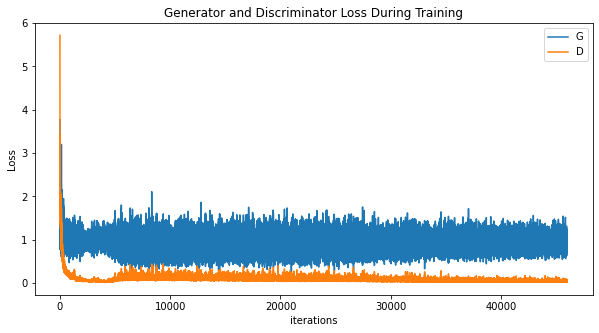

In [24]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

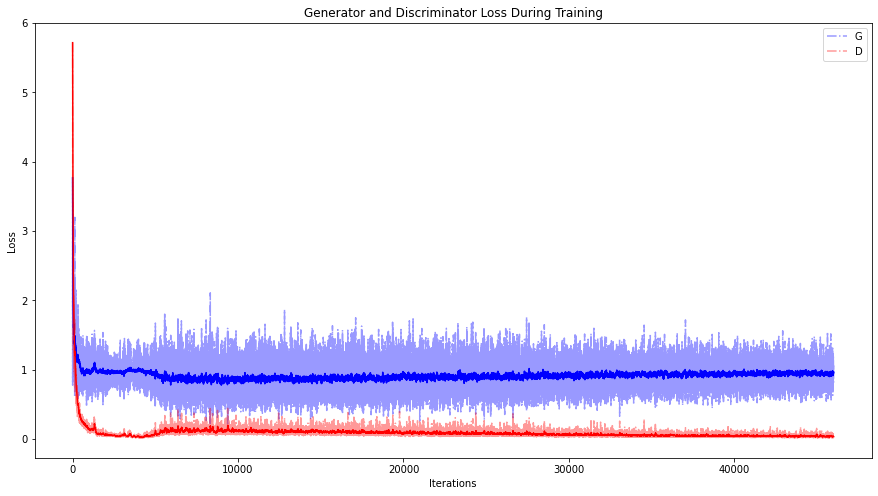

In [25]:
def smooth_curv(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return np.array(smoothed)

plt.figure(figsize=(15, 8))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, 'b-.',label="G", alpha=0.4)
plt.plot(D_losses, 'r-.', label="D", alpha=0.4)
plt.plot(smooth_curv(G_losses, 0.95), 'b')
plt.plot(smooth_curv(D_losses, 0.95), 'r')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




In [26]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




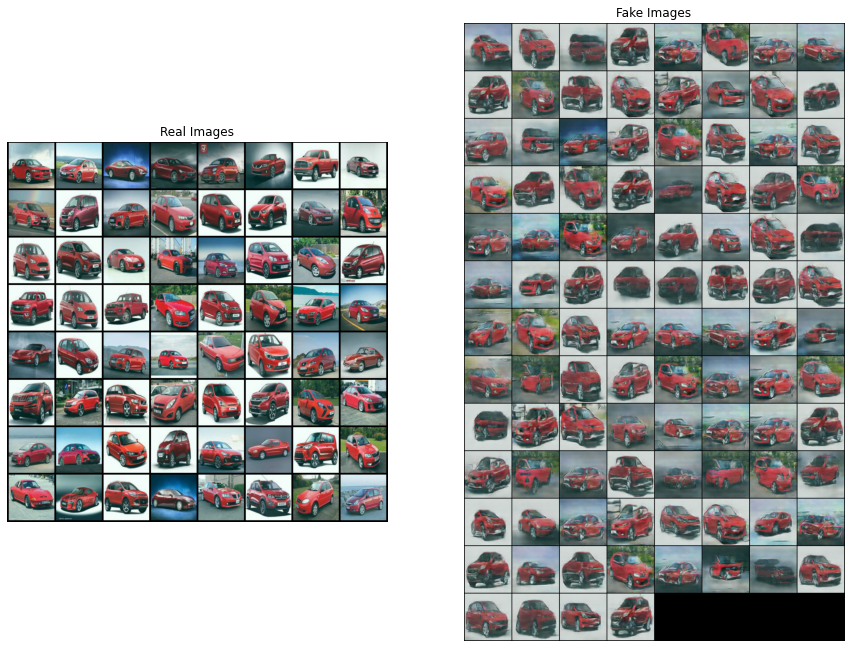

In [27]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Save the Model

In [28]:
torch.save(netG, f'{S6_PROJECT_PATH}red_car_gan_generator.pt')
traced_model = torch.jit.trace(netG.to('cpu'), torch.randn(1, 100, 1, 1))
traced_model.save(f'{S6_PROJECT_PATH}red_car_gan_generator.traced.pt')

In [29]:
# !rm -r CARS
# !rm -r checkpoints
# !rm -r generator_log/

In [30]:
# drive.flush_and_unmount()